In [1]:
## Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from hurst import compute_Hc

import warnings
warnings.filterwarnings("ignore")

In [2]:
## Load files
def load_and_prepare_data(folder_path):
    """Loads and prepares data from CSV files in a given folder."""
    data_frames = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            instrument_name = file_name.split(".csv")[0]
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            asset_name = instrument_name.split("_")[0]
            data_frames[asset_name] = df
    return data_frames

folder_path = 'RawDataDoNotModify'
data_frames = load_and_prepare_data(folder_path)

In [3]:
df = data_frames['BTCUSD']

In [4]:
import pandas as pd
import numpy as np

def calculate_zigzag(df, min_retrace=0.5):
    """
    Calculates the ZigZag indicator and adds 'Zigzag_Value' and 'Zigzag_Dir' columns to the DataFrame.

    Parameters:
    - df: DataFrame containing at least a 'Close' column.
    - min_retrace: Minimum percentage movement to consider a new pivot point.

    Returns:
    - df: DataFrame with added 'Zigzag_Value' and 'Zigzag_Dir' columns.
    """
    close = df['Close']
    length = len(close)

    cur_val = close.iloc[0]
    cur_pos = 0
    cur_dir = 0  # 1 for uptrend, -1 for downtrend, 0 for undefined
    df['Zigzag_Value'] = np.nan
    df['Zigzag_Dir'] = np.nan

    for i in range(1, length):
        price_diff = close.iloc[i] - cur_val
        price_diff_pct = (price_diff / cur_val) * 100

        if cur_dir == 0:
            if abs(price_diff_pct) >= min_retrace:
                cur_dir = 1 if price_diff > 0 else -1
                cur_val = close.iloc[i]
                cur_pos = i
                df.at[df.index[cur_pos], 'Zigzag_Value'] = cur_val
                df.at[df.index[cur_pos], 'Zigzag_Dir'] = cur_dir
        elif cur_dir == 1:
            if close.iloc[i] >= cur_val:
                cur_val = close.iloc[i]
                cur_pos = i
                df.at[df.index[cur_pos], 'Zigzag_Value'] = cur_val
                df.at[df.index[cur_pos], 'Zigzag_Dir'] = cur_dir
            elif close.iloc[i] <= cur_val * (1 - min_retrace / 100):
                cur_dir = -1
                cur_val = close.iloc[i]
                cur_pos = i
                df.at[df.index[cur_pos], 'Zigzag_Value'] = cur_val
                df.at[df.index[cur_pos], 'Zigzag_Dir'] = cur_dir
        elif cur_dir == -1:
            if close.iloc[i] <= cur_val:
                cur_val = close.iloc[i]
                cur_pos = i
                df.at[df.index[cur_pos], 'Zigzag_Value'] = cur_val
                df.at[df.index[cur_pos], 'Zigzag_Dir'] = cur_dir
            elif close.iloc[i] >= cur_val * (1 + min_retrace / 100):
                cur_dir = 1
                cur_val = close.iloc[i]
                cur_pos = i
                df.at[df.index[cur_pos], 'Zigzag_Value'] = cur_val
                df.at[df.index[cur_pos], 'Zigzag_Dir'] = cur_dir
    return df

def find_support_resistance_optimized(df, zigzag_col='Zigzag_Value', dir_col='Zigzag_Dir', 
                                      price_diff=1, time_diff=500, min_points=3):
    """
    Optimized function to identify support and resistance levels from zigzag points in the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing zigzag points with 'Zigzag_Value' and 'Zigzag_Dir' columns.
        zigzag_col (str): Column name for zigzag values (price levels).
        dir_col (str): Column name for zigzag direction.
        price_diff (float): Maximum percentage price difference for grouping.
        time_diff (int): Maximum time difference (index units) for grouping.
        min_points (int): Minimum points required to confirm a level.

    Returns:
        support_levels (list): List of identified support levels.
        resistance_levels (list): List of identified resistance levels.
        df: DataFrame with 'Level' and 'Level_Type' columns added to zigzag points.
    """
    # Extract only rows where zigzag points are present (non-NaN values)
    zigzag_points = df.dropna(subset=[zigzag_col]).copy()
    zigzag_points.reset_index(inplace=True)  # Reset index to use integer indices

    # Pre-compute the price tolerance for grouping
    zigzag_points['Price_Tolerance'] = zigzag_points[zigzag_col] * (price_diff / 100)

    # Add a column to store the level group
    zigzag_points['Level'] = np.nan
    zigzag_points['Level_Type'] = np.nan

    # Use a sliding window for efficient grouping
    visited = set()  # Track visited indices
    level_id = 0  # Unique identifier for each level
    for i in range(len(zigzag_points)):
        if i in visited:
            continue

        # Initialize the group with the current zigzag point
        group = [i]
        visited.add(i)
        cur_value = zigzag_points.loc[i, zigzag_col]
        cur_dir = zigzag_points.loc[i, dir_col]
        price_tolerance = zigzag_points.loc[i, 'Price_Tolerance']

        # Define price range for grouping
        price_range_min = cur_value - price_tolerance
        price_range_max = cur_value + price_tolerance

        for j in range(i + 1, len(zigzag_points)):
            if j in visited:
                continue

            value_j = zigzag_points.loc[j, zigzag_col]

            # Check if value_j is within the price range
            if abs(value_j - cur_value) <= price_tolerance:
                # Check time and direction constraints
                time_diff_check = abs(zigzag_points.loc[j, 'index'] - zigzag_points.loc[i, 'index']) <= time_diff
                dir_check = zigzag_points.loc[j, dir_col] == cur_dir

                if time_diff_check and dir_check:
                    group.append(j)
                    visited.add(j)

        # Only accept groups with enough points
        if len(group) >= min_points:
            avg_price = zigzag_points.loc[group, zigzag_col].mean()
            if cur_dir > 0:
                level_type = 'Resistance'
            else:
                level_type = 'Support'
            # Assign level ID and type to the group
            for idx in group:
                zigzag_points.at[idx, 'Level'] = level_id
                zigzag_points.at[idx, 'Level_Type'] = level_type
            level_id += 1
        else:
            # Not enough points to confirm a level
            pass

    # Merge zigzag_points back to original df
    zigzag_points.set_index('index', inplace=True)
    df = df.merge(zigzag_points[['Level', 'Level_Type']], left_index=True, right_index=True, how='left')

    # Prepare the list of support and resistance levels
    support_levels = []
    resistance_levels = []
    level_groups = zigzag_points.dropna(subset=['Level']).groupby('Level')

    for level_id, group in level_groups:
        level_type = group['Level_Type'].iloc[0]
        avg_price = group[zigzag_col].mean()
        if level_type == 'Support':
            support_levels.append({'Level_ID': level_id, 'Level_Value': avg_price, 'Timestamp': group.index.max()})
        elif level_type == 'Resistance':
            resistance_levels.append({'Level_ID': level_id, 'Level_Value': avg_price, 'Timestamp': group.index.max()})

    return support_levels, resistance_levels, df

def assign_levels_to_df(df, support_levels, resistance_levels, n=3):
    """
    Assigns the last n supports and resistances to each row in the DataFrame.

    Parameters:
    - df: DataFrame containing the original data.
    - support_levels: List of support levels with 'Level_Value' and 'Timestamp'.
    - resistance_levels: List of resistance levels with 'Level_Value' and 'Timestamp'.
    - n: Number of previous supports and resistances to include.

    Returns:
    - df: DataFrame with added support and resistance columns.
    """
    # Initialize columns
    support_cols = [f'support_{i+1}' for i in range(n)]
    resistance_cols = [f'resistance_{i+1}' for i in range(n)]
    for col in support_cols + resistance_cols:
        df[col] = None

    # Sort levels by Timestamp
    support_levels_sorted = sorted(support_levels, key=lambda x: x['Timestamp'])
    resistance_levels_sorted = sorted(resistance_levels, key=lambda x: x['Timestamp'])

    # Initialize lists to keep track of supports and resistances
    supports_list = []
    resistances_list = []

    # Create a dictionary for quick lookup
    support_dict = {level['Timestamp']: level['Level_Value'] for level in support_levels_sorted}
    resistance_dict = {level['Timestamp']: level['Level_Value'] for level in resistance_levels_sorted}

    for idx in df.index:
        # Check if new support/resistance levels are identified at this index
        if idx in support_dict:
            supports_list.append(support_dict[idx])
            supports_list = supports_list[-n:]  # Keep only last n supports
        if idx in resistance_dict:
            resistances_list.append(resistance_dict[idx])
            resistances_list = resistances_list[-n:]  # Keep only last n resistances

        # Assign last n supports to current row
        for i in range(len(supports_list)):
            df.at[idx, support_cols[i]] = supports_list[-(i+1)]
        # Assign last n resistances to current row
        for i in range(len(resistances_list)):
            df.at[idx, resistance_cols[i]] = resistances_list[-(i+1)]

    return df

# Example usage:

# Assuming df is your DataFrame with a 'Close' column
# df = pd.read_csv('your_data.csv')


df = df.reset_index()
# Step 1: Calculate ZigZag points
df = calculate_zigzag(df, min_retrace=0.5)  # You can adjust min_retrace as needed

# Step 2: Identify supports and resistances using the optimized function
support_levels, resistance_levels, df = find_support_resistance_optimized(df, price_diff=1, time_diff=500, min_points=3)

# Step 3: Assign the last three supports and resistances to each row
df = assign_levels_to_df(df, support_levels, resistance_levels, n=3)

# Now, df will have new columns:
# 'support_1', 'support_2', 'support_3', 'resistance_1', 'resistance_2', 'resistance_3'




In [7]:
df.tail()

,index,Local time,Open,High,Low,Close,Volume,Zigzag_Value,Zigzag_Dir,Level,Level_Type,support_1,support_2,support_3,resistance_1,resistance_2,resistance_3
1995,40914,31.08.2024 19:00:00.000 GMT-0400,58987,59013,58901,58939,0.0029,NaN,NaN,NaN,NaN,None,None,None,None,None,None
1996,40915,31.08.2024 20:00:00.000 GMT-0400,58938,59029,58869,58899,0.0054,NaN,NaN,NaN,NaN,None,None,None,None,None,None
1997,40916,31.08.2024 21:00:00.000 GMT-0400,58896,58915,58793,58797,0.0056,NaN,NaN,NaN,NaN,None,None,None,None,None,None
1998,40917,31.08.2024 22:00:00.000 GMT-0400,58796,58812,58248,58505,0.0160,58505.0,-1.0,NaN,NaN,None,None,None,None,None,None
1999,40918,31.08.2024 23:00:00.000 GMT-0400,58505,58626,58378,58483,0.0066,58483.0,-1.0,NaN,NaN,None,None,None,None,None,None


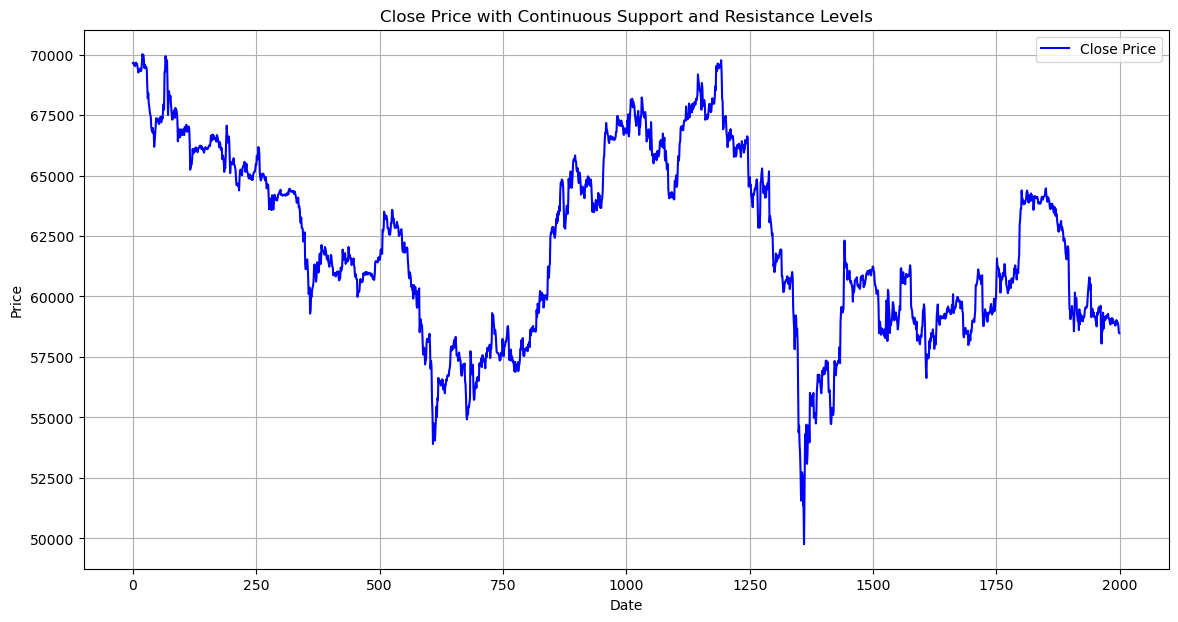

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Previous code to calculate supports and resistances ---

# [Insert the code for calculate_zigzag, find_support_resistance_optimized, and assign_levels_to_df here]

# --- Plotting the Close Price with Continuous Support and Resistance Levels ---

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')

# Function to plot continuous horizontal lines until the next level change
def plot_continuous_levels_until_next(df, level_col, color, label):
    # Identify the points where the level changes
    level_changes = df[level_col].dropna()
    level_indices = level_changes.index.tolist()
    level_values = level_changes.values.tolist()
    for i in range(len(level_indices)):
        idx = level_indices[i]
        level_value = level_values[i]
        # Determine the end index for the horizontal line
        if i < len(level_indices) - 1:
            next_idx = level_indices[i + 1]
        else:
            next_idx = df.index[-1]
        plt.hlines(y=level_value, xmin=df.index[idx], xmax=next_idx, colors=color, linestyles='--', label=label)
        label = None  # Avoid duplicate labels in legend

# Plot 'support_1' and 'resistance_1' using the adjusted function
plot_continuous_levels_until_next(df, 'support_1', color='green', label='Support Level')
plot_continuous_levels_until_next(df, 'resistance_1', color='red', label='Resistance Level')

# Customize the plot
plt.title('Close Price with Continuous Support and Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
